In [1]:
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency
from scipy import stats

In [2]:
x_original=pd.read_csv('../XLable_onlyDiabeticRemoved.txt')
y_original=pd.read_csv('../TargetLable_onlyDiabeticRemoved.txt')

y_original=y_original[['Unnamed: 0','L100700']]

data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')

In [3]:
# data= pd.read_csv('../sep19SexAndAgeAddedFINAL DATASET_ver2.txt',sep=',')

#combine FIELD_6 and FIELD_7 both represent the same thing (Women's marital status)
data['max']=np.min(data[['FIELD_6','FIELD_7']],axis=1)
data=data.drop(columns=['FIELD_6','FIELD_7','B_DAY'])
print(data.shape)


(185843, 407)


In [4]:
# filter the data set 
data=data[data.FIELD_16!=1] # exclude people who are diagnosed for (diabetes) 
data=data[data.FIELD_23!=1] # exclude people who are on medication for diabetes

data=data[data.FIELD_15!=1] # exclude people who are diagnosed for (high blood pressure)
data=data[data.FIELD_22!=1] # exclude people who are on medication for high blood pressure

data=data[data.FIELD_17!=1] # exclude people who are diagnosed for hyperlipidemia
data=data[data.FIELD_24!=1] # exclude people who are on medication for hyperlipidemia

print(data.shape)

(169024, 407)


In [5]:
#split column types to categorical and numerical
numerical_cols = list(data.columns[~data.columns.str.startswith('FIELD')])
categorical_cols = list(data.columns[data.columns.str.startswith('FIELD')])

Calculate correlation Value - for numerical values
========

In [6]:
corr=data[numerical_cols].corr()
corr=corr.L100700_y
corrvalPD=pd.DataFrame()
corrvalPD['Col']=corr.index
corrvalPD['val']=abs(corr.values)

corrvalPD=corrvalPD.sort_values(by='val',ascending=False)
corrvalPD.head()

,Col,val
277,L100700_y,1.000000
129,L368900,1.000000
133,L393800,1.000000
117,L303203,0.962250
118,L303204,0.946729


In [7]:
#count of none NA values of feature set
mydataset=data.copy()[numerical_cols]
colCount=[]
for i in mydataset.columns:
    colCount.append([i,mydataset[i].dropna().shape[0]])

colCountPD=pd.DataFrame(colCount,columns=['Col','Count'])
colCountPD.head()

,Col,Count
0,Unnamed: 0,169024
1,index,169024
2,COMPARE,169024
3,AGE,169024
4,SEX,169024


In [8]:
mergedColCorrCount=pd.merge(corrvalPD,colCountPD,how='inner',left_on='Col',right_on='Col')
mergedColCorrCount=mergedColCorrCount[mergedColCorrCount.Count>75000]
mergedColCorrCount=mergedColCorrCount.sort_values(by='val', ascending=False)
mergedColCorrCount.head(20)

,Col,val,Count
0,L100700_y,1.000000,163328
8,L100700_x,0.852570,161652
11,SEX,0.615337,169024
15,L190400,0.508749,168879
16,L100500,0.491801,168589
17,L190500,0.487764,168841
18,L190300,0.476002,168841
19,S000100,0.462359,168939
21,S000300,0.417979,168710
22,L103300,0.396840,143521


In [9]:
print(list(mergedColCorrCount.head(22).Col))

['L100700_y', 'L100700_x', 'SEX', 'L190400', 'L100500', 'L190500', 'L190300', 'S000100', 'S000300', 'L103300', 'L103000', 'L103100', 'S000501', 'L101300', 'L101700', 'S000502', 'L190800', 'L107400', 'L100200', 'L100800', 'L101600', 'L101200']


Anova test - For categorical values [Questionnaire answers]
=======

In [10]:
mydataset=data.copy()[categorical_cols] 

mydataset=mydataset.drop(columns=['FIELD_1','FIELD_2','FIELD_87','FIELD_8','FIELD_10','FIELD_11','FIELD_12','FIELD_39',
                                  'FIELD_88','FIELD_89', 'FIELD_108','FIELD_109','FIELD_110','FIELD_111','FIELD_82',
                                 'FIELD_91','FIELD_103','FIELD_118','FIELD_119','FIELD_120','FIELD_121','FIELD_122',
                                 'FIELD_123','FIELD_124','FIELD_125','FIELD_126','FIELD_127','FIELD_128','FIELD_129',
                                 'FIELD_130','FIELD_131','FIELD_132','FIELD_133','FIELD_134','FIELD_135','FIELD_136',
                                  'FIELD_137','FIELD_138','FIELD_139','FIELD_140',
                                  'FIELD_64','FIELD_65','FIELD_66','FIELD_67','FIELD_68','FIELD_69','FIELD_70','FIELD_72',
                                  'FIELD_73','FIELD_74','FIELD_75','FIELD_76','FIELD_77','FIELD_80','FIELD_81','FIELD_84',
                                  'FIELD_85','FIELD_90','FIELD_93','FIELD_94','FIELD_95','FIELD_96','FIELD_97','FIELD_98',
                                  'FIELD_101','FIELD_102','FIELD_105','FIELD_106','FIELD_112','FIELD_113','FIELD_114',
                                  'FIELD_115','FIELD_116','FIELD_117','FIELD_118','FIELD_119','FIELD_9'])


mydataset=mydataset.drop(mydataset[mydataset.FIELD_3=='`'].index)
mydataset=mydataset.drop(mydataset[mydataset.FIELD_3=='G'].index)


mydataset=mydataset.drop(mydataset[mydataset.FIELD_4=='.'].index)
mydataset=mydataset.drop(mydataset[mydataset.FIELD_5=='.'].index)

mydataset=mydataset.drop(mydataset[mydataset.FIELD_35=='?'].index)
mydataset=mydataset.drop(mydataset[mydataset.FIELD_35=='.'].index)
mydataset=mydataset.drop(mydataset[mydataset.FIELD_36=='.'].index)
mydataset=mydataset.drop(mydataset[mydataset.FIELD_37=='\\'].index)
 
# mydataset=mydataset.drop(mydataset[mydataset.FIELD_39 == '7+' ].index)
# mydataset=mydataset.drop(mydataset[mydataset.FIELD_39 == '5~7'].index)
# mydataset=mydataset.drop(mydataset[mydataset.FIELD_39 == '3-4'].index)


# mydataset=mydataset.drop(mydataset[mydataset.FIELD_95=='.'].index)

In [11]:
colslist=mydataset.columns
DiabeticColVals=data.L100700_y

cor=[]
pval=[]
count=[]

for i in range(len(colslist)):
    print(i,colslist[i])
    
    temp=pd.DataFrame([])
    temp['a']=DiabeticColVals
    temp['b']=mydataset[colslist[i]].astype(float)
    temp=temp.dropna()
    count.append(temp.shape[0])
    
    uniquevalues=temp.b.unique()
    
    selectedGroupVals=[]
    for k in range(len(uniquevalues)):
        selectedGroupVals.append(np.asarray(temp[temp['b']==uniquevalues[k]].a))

    F, p = stats.f_oneway(*selectedGroupVals)
    cor.append(F)
    pval.append(p)
    

0 FIELD_3
1 FIELD_4
2 FIELD_5
3 FIELD_13
4 FIELD_14
5 FIELD_15
6 FIELD_16
7 FIELD_17
8 FIELD_18
9 FIELD_19
10 FIELD_20
11 FIELD_21
12 FIELD_22
13 FIELD_23
14 FIELD_24
15 FIELD_25
16 FIELD_26
17 FIELD_27
18 FIELD_28
19 FIELD_29
20 FIELD_30
21 FIELD_31
22 FIELD_32
23 FIELD_33
24 FIELD_34
25 FIELD_35
26 FIELD_36
27 FIELD_37
28 FIELD_38
29 FIELD_40
30 FIELD_41
31 FIELD_42
32 FIELD_43
33 FIELD_44
34 FIELD_45
35 FIELD_46
36 FIELD_47
37 FIELD_48
38 FIELD_49
39 FIELD_50
40 FIELD_51
41 FIELD_52
42 FIELD_53
43 FIELD_54
44 FIELD_55
45 FIELD_56
46 FIELD_57
47 FIELD_58
48 FIELD_59
49 FIELD_60
50 FIELD_61
51 FIELD_62
52 FIELD_63


In [12]:

FvalPvalCorr=pd.DataFrame()    
FvalPvalCorr['Cols']=colslist
FvalPvalCorr['F']=cor
FvalPvalCorr['P']=pval
FvalPvalCorr['Count']=count
FvalPvalCorr=FvalPvalCorr.sort_values(by='F', ascending=False)


In [13]:
FvalPvalCorr[FvalPvalCorr.Count>50000].head(30)

,Cols,F,P,Count
23,FIELD_33,5566.203159,0.000000e+00,163015
28,FIELD_38,1776.645851,0.000000e+00,163022
29,FIELD_40,354.702317,0.000000e+00,163025
8,FIELD_18,160.754992,8.055206e-37,163310
15,FIELD_25,157.353941,4.451118e-36,163311
30,FIELD_41,143.889395,1.534268e-212,162995
19,FIELD_29,134.398643,4.596795e-31,163310
31,FIELD_42,67.325637,5.615510e-111,162972
11,FIELD_21,27.799962,1.346993e-07,163311
1,FIELD_4,26.556775,1.163360e-36,160816


In [14]:
print(list(FvalPvalCorr[FvalPvalCorr.Count>50000].Cols)[:10])

['FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_18', 'FIELD_25', 'FIELD_41', 'FIELD_29', 'FIELD_42', 'FIELD_21', 'FIELD_4']


=====================
============

In [16]:
mydata=data[['L100700_y', 'L100700_x', 'SEX', 'L190400', 'L100500', 'L190500', 'L190300', 'S000100', 'S000300', 
             'L103300', 'L103000', 'L103100', 'S000501', 'L101300', 'L101700', 'S000502', 'L190800', 'L107400', 
             'L100200', 'L100800', 'L101600', 'L101200','FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_18', 
             'FIELD_25', 'FIELD_41', 'FIELD_29', 'FIELD_42', 'FIELD_21', 'FIELD_4']].dropna()

# mydata=mydata.drop(mydata[mydata.FIELD_4=='.'].index)
 

x=mydata[['L100700_x', 'SEX', 'L190400', 'L100500', 'L190500', 'L190300', 'S000100', 'S000300', 
             'L103300', 'L103000', 'L103100', 'S000501', 'L101300', 'L101700', 'S000502', 'L190800', 'L107400', 
             'L100200', 'L100800', 'L101600', 'L101200','FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_18', 
             'FIELD_25', 'FIELD_41', 'FIELD_29', 'FIELD_42', 'FIELD_21', 'FIELD_4']]

y=mydata[['L100700_y']]

In [28]:
# # from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(x,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

# x=x[x.columns[:15]]
print(list(x.columns[:12]))

# 'L103000_x', 'L100700', 'L101700', 'S000300', 'L100800', 'L101300', 'S000501', 'S000502', 'L100500', 'S000100', 'L190000', 'L101600'

['L100700_x', 'L100500', 'S000100', 'S000300', 'L103300', 'L103000', 'L103100', 'S000501', 'L101300', 'L101700', 'S000502', 'L107400']


[6.20861200e-01 1.78194527e-02 5.84394247e-02 2.22536533e-02
 1.41349866e-02 1.69641972e-02 1.62847204e-02 1.90937466e-02
 1.16046522e-02 1.11035591e-02 1.24078635e-02 1.49778242e-02
 1.34435987e-02 1.38213838e-02 1.18659763e-02 1.09379763e-02
 4.46758634e-02 1.93429035e-02 9.62227258e-03 1.79774693e-03
 1.50307474e-03 1.03169546e-02 5.26793261e-03 1.10026906e-02
 5.68111358e-04 9.88823410e-03]


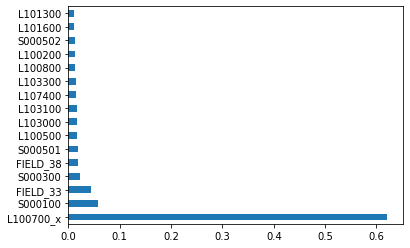

Index(['L100700_x', 'S000100', 'FIELD_33', 'S000300', 'FIELD_38', 'S000501',
       'L100500', 'L103000', 'L103100', 'L107400', 'L103300', 'L100800'],
      dtype='object')


In [29]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(x,y)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

print(feat_importances.nlargest(12).index)

In [19]:
# import seaborn as sns
# temppd=pd.DataFrame(data[['L104600', 'L100800', 'L103300', 'AGE', 'L103000', 'S000300', 'L102900', 'L101600', 
#                           'S000501', 'L103200', 'L103100', 'L101700', 'L101300', 'S000502', 'L190000', 'L190300', 
#                           'L504700', 'L101100', 'L100400', 'SEX','FIELD_31', 'FIELD_33', 'FIELD_21', 'FIELD_27', 
#                           'FIELD_14', 'FIELD_28', 'FIELD_38', 'FIELD_4', 'FIELD_18', 'FIELD_29']]).dropna()  
# temppd['y']=data.L104600
 

# corr = (temppd.corr())
# sns.heatmap(corr, vmin=-1, vmax=1) 

# corr.head(20)

In [21]:

def vifcal(inputdata,depcol):
    vifL5=[]
    import statsmodels.formula.api as sm
    xvars=inputdata.drop([depcol],axis=1)
    xvarnames=xvars.columns
    for i in range(0,xvarnames.shape[0]):
        _y=xvars[xvarnames[i]]
        _x=xvars[xvarnames.drop(xvarnames[i])]
        rsq=sm.ols(formula="_y~_x",data=xvars).fit().rsquared
        vif=round(1/(1-rsq),2)
        print(i,', ',xvarnames[i]," VIF = ",vif)
        if(vif<5):
            vifL5.append(xvarnames[i])
    return vifL5
    
    
newcols = vifcal(mydata,'L100700_y')
print(newcols)

0 ,  L100700_x  VIF =  2.06
1 ,  SEX  VIF =  5.11
2 ,  L190400  VIF =  569.12
3 ,  L100500  VIF =  2.11
4 ,  L190500  VIF =  431.66
5 ,  L190300  VIF =  5.6
6 ,  S000100  VIF =  2.27
7 ,  S000300  VIF =  1.73
8 ,  L103300  VIF =  3.24
9 ,  L103000  VIF =  1.91
10 ,  L103100  VIF =  2.59
11 ,  S000501  VIF =  2.81
12 ,  L101300  VIF =  3.08
13 ,  L101700  VIF =  1.6
14 ,  S000502  VIF =  2.56
15 ,  L190800  VIF =  40.9
16 ,  L107400  VIF =  1.18
17 ,  L100200  VIF =  1.28
18 ,  L100800  VIF =  1.28
19 ,  L101600  VIF =  1.22
20 ,  L101200  VIF =  2.48
21 ,  FIELD_33  VIF =  1.64
22 ,  FIELD_38  VIF =  1.37
23 ,  FIELD_40  VIF =  1.64
24 ,  FIELD_18  VIF =  2.6
25 ,  FIELD_25  VIF =  2.6
26 ,  FIELD_41  VIF =  1.74
27 ,  FIELD_29  VIF =  1.01
28 ,  FIELD_42  VIF =  1.14
29 ,  FIELD_21  VIF =  1.01
30 ,  FIELD_4  VIF =  1.02
['L100700_x', 'L100500', 'S000100', 'S000300', 'L103300', 'L103000', 'L103100', 'S000501', 'L101300', 'L101700', 'S000502', 'L107400', 'L100200', 'L100800', 'L101600'

In [27]:
mydata=data[['L100700_y','L100700_x', 'L100500', 'S000100', 'S000300', 'L103300', 'L103000', 'L103100', 'S000501', 
             'L101300', 'L101700', 'S000502', 'L107400', 'L100200', 'L100800', 'L101600', 'L101200', 
             'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_18', 'FIELD_25', 'FIELD_41', 'FIELD_29', 
             'FIELD_42', 'FIELD_21', 'FIELD_4']].dropna()

x=mydata[['L100700_x', 'L100500', 'S000100', 'S000300', 'L103300', 'L103000', 'L103100', 'S000501', 
             'L101300', 'L101700', 'S000502', 'L107400', 'L100200', 'L100800', 'L101600', 'L101200', 
             'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_18', 'FIELD_25', 'FIELD_41', 'FIELD_29', 
             'FIELD_42', 'FIELD_21', 'FIELD_4']]

y=mydata[['L100700_y']]